In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [2]:
train = pd.read_csv(r'E:\PQJ\just do it\房租预测\train_data.csv')
test = pd.read_csv(r'E:\PQJ\just do it\房租预测\test_a.csv')

In [3]:
length = len(train)

train['rentType'][train['rentType']=='--'] = '未知方式'
print('rentType:',list(train['rentType']).count("未知方式")/length)
print('houseToward:',list(train['houseToward']).count("暂无数据")/length)
print('houseDecoration:',list(train['houseDecoration']).count("其他")/length)
print('buildYear:',list(train['buildYear']).count("暂无信息")/length)

rentType: 0.7423745173745174
houseToward: 0.02323841698841699
houseDecoration: 0.7007722007722008
buildYear: 0.06776061776061776


d:\python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


其中rentType和houseDecoration缺失值的比列达到70%，考虑将这两特征去除

In [4]:
def parseData(df):
    """
    预处理数据
    """
    # 去掉部分特征
    df.drop('ID', axis=1, inplace=True)#没意义的特征
    df.drop('communityName',axis=1, inplace=True)#没意义的特征
    df.drop('city',axis=1,inplace=True)#单调特征列，只有一个值
    df.drop('rentType',axis=1, inplace=True)
    df.drop('houseDecoration',axis=1,inplace=True)
    
    # 转换object类型数据
    columns = [ 'houseFloor', 'houseToward', 'region', 'plate']
    for col in columns:
        df[col] = df[col].astype('category')
        
    # 将buildYear列转换为整型数据
    tmp = df['buildYear'].copy()
    tmp2 = tmp[tmp!='暂无信息'].astype('int')#先转整形
    tmp[tmp=='暂无信息'] = tmp2.mode().iloc[0]#用众数填充独特的缺失值：'暂无信息'
    df['buildYear'] = tmp
    df['buildYear'] = df['buildYear'].astype('int')
    
    # 处理pv和uv的空值  uv和pv训练集和测试集分布类似，存在长尾现象，所以用均值填充
    df['pv'].fillna(df['pv'].mean(),inplace=True)
    df['uv'].fillna(df['uv'].mean(),inplace=True)
    df['pv'] = df['pv'].astype('int')
    df['uv'] = df['uv'].astype('int')
    
    
    return df

In [5]:
print(test[['area']].describe())
print(test[['region','plate']].describe())

              area
count  2469.000000
mean     76.031839
std      29.080334
min      15.000000
25%      53.000000
50%      73.160000
75%      94.320000
max     150.000000
         region    plate
count      2469     2469
unique       14       63
top     RG00002  BK00056
freq        724      125


通过测试集看到area范围在15-150之间

In [6]:
train["region"].value_counts(),test["region"].value_counts()

(RG00002    11437
 RG00005     5739
 RG00003     4186
 RG00010     3640
 RG00012     3368
 RG00004     3333
 RG00006     1961
 RG00007     1610
 RG00008     1250
 RG00013     1215
 RG00001     1157
 RG00014     1069
 RG00011      793
 RG00009      681
 RG00015        1
 Name: region, dtype: int64, RG00002    724
 RG00005    311
 RG00012    262
 RG00010    194
 RG00003    178
 RG00004    153
 RG00007    142
 RG00013     97
 RG00008     86
 RG00014     86
 RG00001     77
 RG00009     61
 RG00006     55
 RG00011     43
 Name: region, dtype: int64)

删掉训练集中得RG00015

In [7]:
print(train["plate"].value_counts(),test["plate"].value_counts())
print(train["plate"].value_counts().iloc[0])
train_pla = train["plate"].value_counts().keys()
test_pla = test["plate"].value_counts().keys()
print("*"*20)
# find different
for i in train_pla:
    if i not in test_pla:
        print(i)

BK00031    1958
BK00033    1837
BK00045    1816
BK00055    1566
BK00056    1516
BK00052    1375
BK00017    1305
BK00041    1266
BK00054    1256
BK00051    1253
BK00046    1227
BK00035    1156
BK00042    1137
BK00009    1016
BK00050     979
BK00043     930
BK00026     906
BK00047     880
BK00034     849
BK00013     834
BK00053     819
BK00028     745
BK00040     679
BK00060     671
BK00010     651
BK00029     646
BK00062     618
BK00022     614
BK00018     613
BK00064     590
           ... 
BK00037     444
BK00012     412
BK00038     398
BK00024     397
BK00020     384
BK00002     357
BK00065     348
BK00027     344
BK00039     343
BK00063     281
BK00057     278
BK00015     253
BK00006     231
BK00021     226
BK00007     225
BK00030     219
BK00066     219
BK00049     211
BK00008     210
BK00004     189
BK00048     165
BK00025     157
BK00023     127
BK00059     122
BK00044      98
BK00016      40
BK00036      33
BK00058      15
BK00032       3
BK00001       1
Name: plate, Length: 66,

In [8]:
def washData(df_train, df_test):
    """
    清洗数据
    """
    df_train = df_train[(df_train['area']<=230) & (df_train['area']>=5)]#比例大概是99%
    df_train = df_train[df_train['remainNewNum'] < 3000]
    df_train = df_train[df_train['tradeMoney']<=25000]
    
    df_train = df_train.drop(df_train[df_train['region']=="RG00015"].index)

    df_trian = df_train.drop(df_train[(df_train["plate"] == "BK00058")|(df_train["plate"] == "BK00032")|(df_train["plate"] == "BK00001")].index)
    
    return df_train, df_test


In [9]:
def feature(df):
    """
    特征工程
    """
    # 将houseType转化为‘房间数’，‘厅数’，‘卫生间数’
    def parseRoom(info, index):
        res = int(info[index*2])
        return res
    df.insert(3,'室',None)
    df.insert(4, '厅', None)
    df.insert(5, '卫', None)
    df.insert(6,'房间总数',None)
    df['室'] = df['houseType'].apply(parseRoom, index=0)#将这一列的每一个值以str形式传入parseRoom函数中，返回info[index]
    df['厅'] = df['houseType'].apply(parseRoom, index=1)
    df['卫'] = df['houseType'].apply(parseRoom, index=2)
    df.drop('houseType', axis=1, inplace=True)
    #房间总数
    df['房间总数'] = df["室"] + df["卫"] + df["厅"]
   
    #交易月份
    df['交易月份'] = df['tradeTime'].apply(lambda x: int(x.split('/')[1]))  #以 / 分割，返回list，取[1]即月份
    df.drop('tradeTime', axis=1, inplace=True)
    
    #平方均价
    df["tradeMean"] = df["totalTradeMoney"]/df["totalTradeArea"]
    df["tradeNewMean"] = df["totalNewTradeMoney"]/df["totalNewTradeArea"]
    
    #周围建筑类型
    df['stationnum'] = df['subwayStationNum'] + df['busStationNum']
    df['schoolnum'] = df['interSchoolNum'] + df['schoolNum'] + df['privateSchoolNum']
    df['medicalnum'] = df['hospitalNum'] + df['drugStoreNum']
    df['sportnum'] = df['gymNum'] + df['parkNum']
    df['marketnum'] = df['shopNum'] + df['mallNum'] + df['superMarketNum']
    df = df.drop(['subwayStationNum','busStationNum', 'schoolNum',
                  'interSchoolNum', 'privateSchoolNum',
                  'hospitalNum', 'drugStoreNum',
                  'gymNum',  'parkNum',
                  'shopNum', 'mallNum', 'superMarketNum'], axis=1)
    
    
    
    
    
    categorical_feats = [ 'houseFloor', 'houseToward', 'region', 'plate']
    return df, categorical_feats

In [10]:
def getData(feature):
    """
    获取数据
    """
    train = pd.read_csv(r'E:\PQJ\just do it\房租预测\train_data.csv')
    test = pd.read_csv(r'E:\PQJ\just do it\房租预测\test_a.csv')
    
    train = parseData(train)
    test = parseData(test)
    train, test = washData(train, test)
    
    train, col = feature(train)
    test, col = feature(test)
    
    target = train.pop('tradeMoney')
    features = train.columns
    categorical_feats = col
    
    return train, test, target, features, categorical_feats

In [11]:
train, test, target, features, categorical_feats = getData(feature)

In [19]:
train.shape

(40884, 43)

# 特征选择

**卡方**

In [28]:
from sklearn.feature_selection import SelectKBest,SelectPercentile
from sklearn.feature_selection import chi2

X = train
y = target

# 去掉字符型特征
for col in X.columns:
    if X[col].dtype.name == "category":
        X = X.drop([col],axis=1)

X = X.fillna(0)#对NaN值填充为0

X_new = SelectKBest(chi2, k='all').fit_transform(X, y)
X_new

array([[ 68.06,   2.  ,   1.  , ...,  13.  ,  20.  , 101.  ],
       [125.55,   3.  ,   2.  , ...,  28.  ,  11.  , 218.  ],
       [132.  ,   3.  ,   2.  , ...,  27.  ,  41.  , 119.  ],
       ...,
       [  9.2 ,   4.  ,   1.  , ...,  75.  ,  49.  , 319.  ],
       [ 14.1 ,   4.  ,   1.  , ...,  75.  ,  49.  , 319.  ],
       [ 33.5 ,   1.  ,   1.  , ...,  53.  ,  50.  , 428.  ]])

**Wrapper （RFE）**

In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=43)
rfe.fit_transform(X,y)

array([[ 68.06,   2.  ,   1.  , ...,  13.  ,  20.  , 101.  ],
       [125.55,   3.  ,   2.  , ...,  28.  ,  11.  , 218.  ],
       [132.  ,   3.  ,   2.  , ...,  27.  ,  41.  , 119.  ],
       ...,
       [  9.2 ,   4.  ,   1.  , ...,  75.  ,  49.  , 319.  ],
       [ 14.1 ,   4.  ,   1.  , ...,  75.  ,  49.  , 319.  ],
       [ 33.5 ,   1.  ,   1.  , ...,  53.  ,  50.  , 428.  ]])

**Embedded**

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
 
#带L1惩罚项的逻辑回归作为基模型的特征选择
SelectFromModel(LogisticRegression(penalty="l1", C=0.1)).fit_transform(X, y)

d:\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\python\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
 
#GBDT作为基模型的特征选择
SelectFromModel(GradientBoostingClassifier()).fit_transform(X, y)

# 贡献值

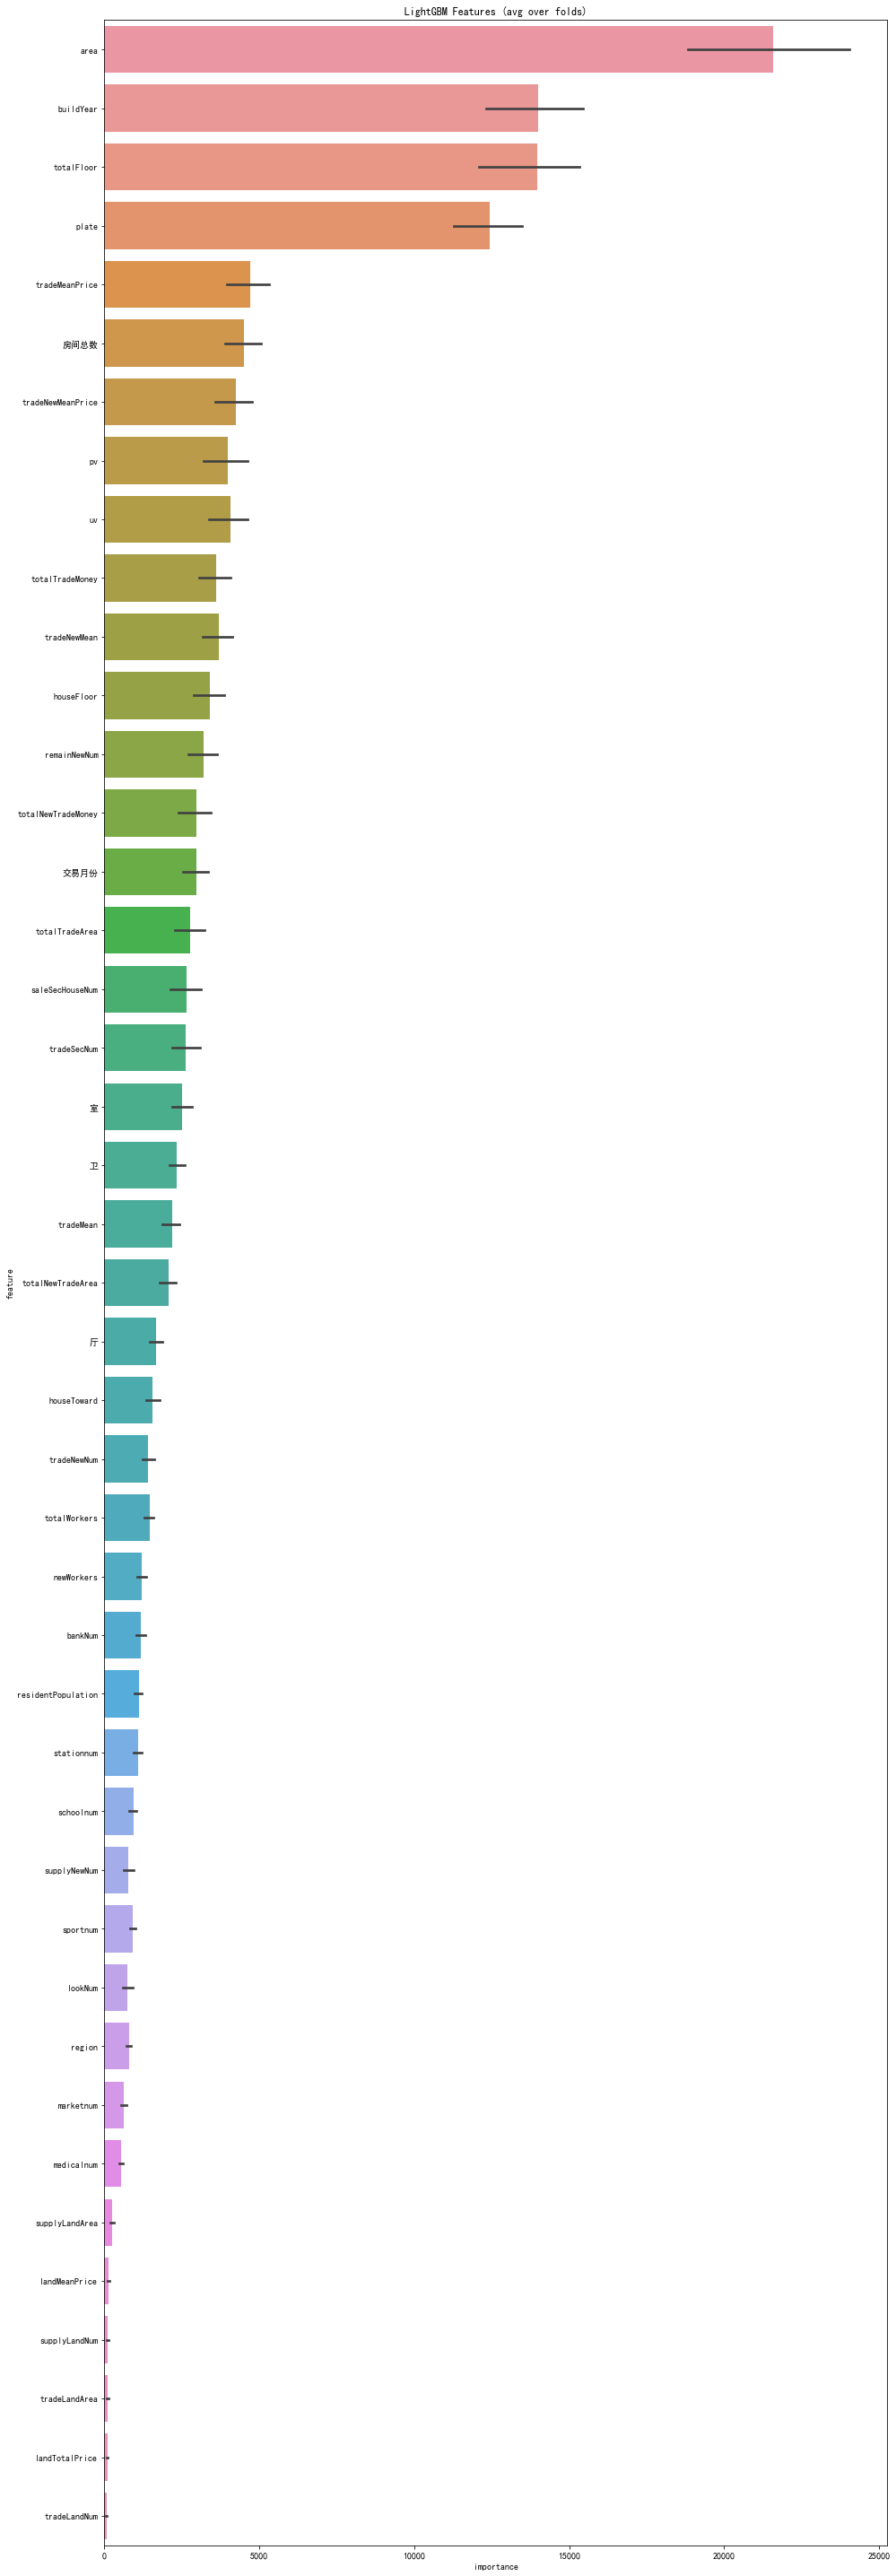

In [14]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()


# 模型选择

In [12]:
params = {
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'min_child_samples':20,
    'objective': 'regression',
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}

In [13]:

folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()


for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    print(trn_idx, val_idx)
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx], categorical_feature=categorical_feats)
    
    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))

fold 0
[    5     6     7 ... 40881 40882 40883] [    0     1     2 ... 40870 40876 40878]


d:\python\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\python\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 965.985	valid_1's rmse: 1077.99
[1000]	training's rmse: 868.366	valid_1's rmse: 1051.69
[1500]	training's rmse: 807.721	valid_1's rmse: 1041.77
[2000]	training's rmse: 762.49	valid_1's rmse: 1035.47
[2500]	training's rmse: 726.861	valid_1's rmse: 1031.79
[3000]	training's rmse: 697.46	valid_1's rmse: 1029.74
[3500]	training's rmse: 671.837	valid_1's rmse: 1029.21
Early stopping, best iteration is:
[3405]	training's rmse: 676.222	valid_1's rmse: 1029.08
fold 1
[    0     1     2 ... 40880 40881 40882] [    7    10    16 ... 40865 40879 40883]
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 977.8	valid_1's rmse: 1046.13
[1000]	training's rmse: 881.124	valid_1's rmse: 1009.67
[1500]	training's rmse: 820.053	valid_1's rmse: 993.911
[2000]	training's rmse: 773.578	valid_1's rmse: 984.205
[2500]	training's rmse: 737.342	valid_1's rmse: 977.848
[3000]	training's rmse: 70

In [ ]:
import xgboost as xgb
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = xgb.DMatrix(train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(train.iloc[val_idx], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    num_round = 10000
    clf = xgb.train(dtrain=trn_data,num_boost_round=10000, evals=watchlist, early_stopping_rounds=200,
                            verbose_eval=1000, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(train.loc[val_idx]), ntree_limit=clf.best_ntree_limit)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_xgb += clf.predict(xgb.DMatrix(test),
                                           ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_xgb)))

In [ ]:
import catboost as cat
ctb_params = {
    'n_estimators': 10000,
    'learning_rate': 0.02,
    'random_seed': 4590,
    'reg_lambda': 0.08,
    'subsample': 0.7,
    'bootstrap_type': 'Bernoulli',
    'boosting_type': 'Plain',
    'one_hot_max_size': 10,
    'rsm': 0.5,
    'leaf_estimation_iterations': 5,
    'use_best_model': True,
    'max_depth': 6,
    'verbose': -1,
    'thread_count': 4
    }
le =LabelEncoder()
train['rentType'] = le.fit_transform(train['rentType'])
train['houseFloor'] = le.fit_transform(train['houseFloor'])
train['communityName'] = le.fit_transform(train['communityName'])
train['plate'] = le.fit_transform(train['plate'])
train['houseType_1sumcsu'] = le.fit_transform(train['houseType_1sumcsu'])
train['houseType_2sumcsu'] = le.fit_transform(train['houseType_2sumcsu'])
train['houseType_3sumcsu'] = le.fit_transform(train['houseType_3sumcsu'])
test['rentType'] = le.fit_transform(test['rentType'])
test['houseFloor'] = le.fit_transform(test['houseFloor'])
test['communityName'] = le.fit_transform(test['communityName'])
test['plate'] = le.fit_transform(test['plate'])
test['houseType_1sumcsu'] = le.fit_transform(test['houseType_1sumcsu'])
test['houseType_2sumcsu'] = le.fit_transform(test['houseType_2sumcsu'])
test['houseType_3sumcsu'] = le.fit_transform(test['houseType_3sumcsu'])
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_cat = np.zeros(len(train))
predictions_cat = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_ + 1))
    clf = cat.CatBoostRegressor(**ctb_params)
    clf.fit(train.iloc[trn_idx], target.iloc[trn_idx], early_stopping_rounds=200, verbose_eval=3000,
                use_best_model=True,eval_set=(train.iloc[val_idx], target.iloc[val_idx]))
    oof_cat[val_idx] = clf.predict(train.iloc[val_idx])
    predictions_cat += clf.predict(test) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
   
    predictions_cat += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_cat)))